# Multi-Trend Following Momentum

Societe Generale: Momentum strategies in credit: A review of different trend strategies applied to credit indices

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import tsmoothie as ts

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

from CreditDataPrep import CreditDataPrep

## Get Data

In [2]:
def _get_rtn(df: pd.DataFrame) -> pd.DataFrame: 
    
    return(df.sort_values(
        "date").
        assign(rtn = lambda x: x.value.pct_change()).
        dropna())

def get_data() -> pd.DataFrame: 
    
    df_raw = CreditDataPrep().get_data()

    df_log_spread = (df_raw.query(
        "group_short == 'Spread'").
        assign(log_spread = lambda x: np.log(x.value)))

    df_index = (df_raw.query(
        "asset_class == 'CDS' & group_short == 'Index'").
        drop(columns = ["group_short", "asset_class"]).
        assign(group_name = lambda x: x.security.str.split(" ").str[1]).
        groupby("security").
        apply(_get_rtn).
        reset_index(drop = True))
    
    return df_log_spread, df_index

df_log_spread, df_index = get_data()

In [3]:
def get_spread_change(df_log_spread: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df_log_spread.assign(
        name = lambda x: x.security.str.split("CDSI").str[0],
        day_name = lambda x: x.date.dt.day_name()).
        query("day_name == 'Monday'").
        drop(columns = ["day_name"])
        [["date", "name", "value", "log_spread"]].
        rename(columns = {"value": "spread"}).
        melt(id_vars = ["date", "name"]).
        assign(name = lambda x: x.name  + x.variable.str.replace("_", " "))
        [["date", "name", "value"]].
        pivot(index = "date", columns = "name", values = "value").
        diff().
        reset_index().
        melt(id_vars = "date").
        dropna())
    
    return df_out

df_spread_change = get_spread_change(df_log_spread)

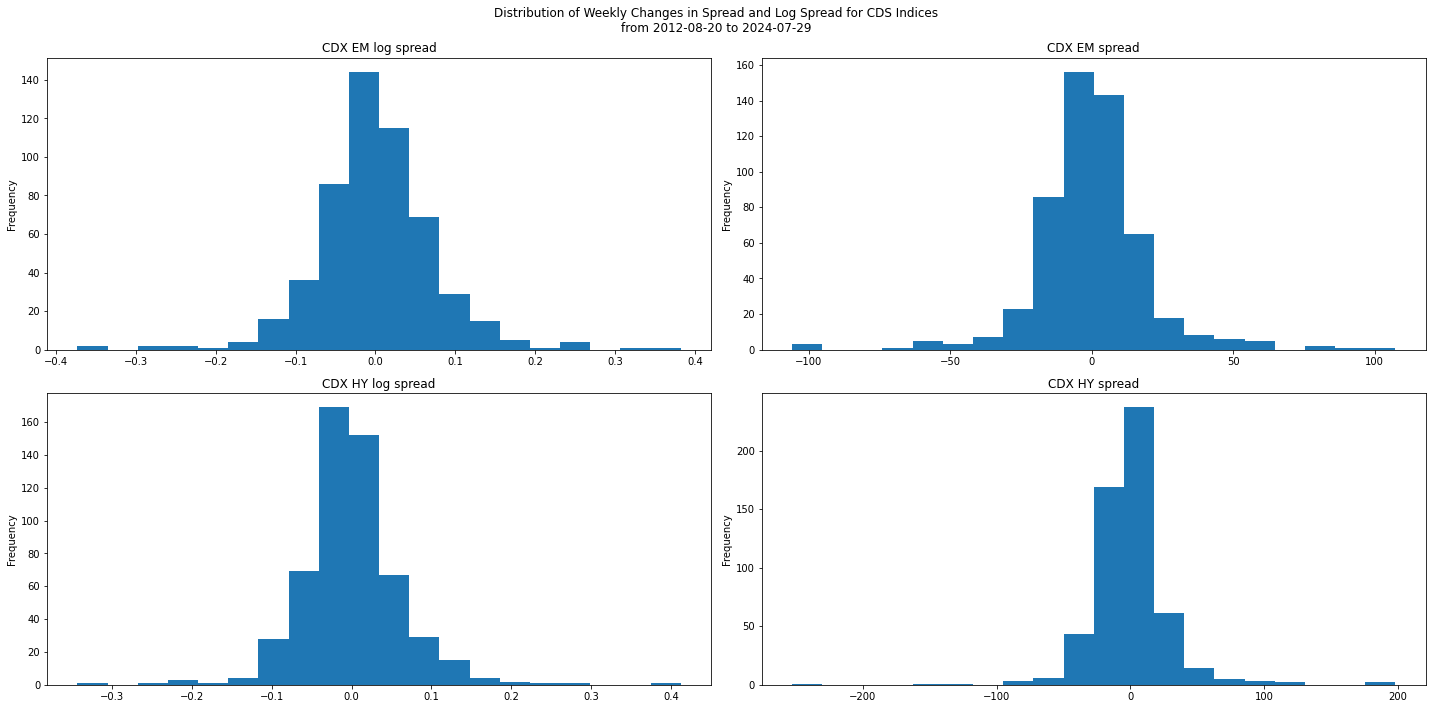

In [4]:
def plot_spread_distribution(df_spread_change: pd.DataFrame) -> pd.DataFrame:

    names = df_spread_change.name.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(names) // 2, nrows = len(names) // 2, figsize = (20,10))

    for name, ax in zip(names, axes.flatten()):

        (df_spread_change.query(
            "name == @name")
            [["value"]].
            plot(
                kind = "hist",
                ax = ax,
                xlabel = "Difference",
                legend = False,
                title = name,
                bins = 20))

        ax.xaxis.set_label("Spread Difference")

    fig.suptitle("Distribution of Weekly Changes in Spread and Log Spread for CDS Indices\nfrom {} to {}".format(
        df_spread_change.date.min().date(),
        df_spread_change.date.max().date()))
    plt.tight_layout()
    
plot_spread_distribution(df_spread_change)

# Moving Average and Regression Lines on log-spread

Going to use this method<br>
1. 10dx30d EWMA Crossover Strategy
2. Sign of 20d Lagged Beta

In [5]:
def _get_ewmac(df: pd.DataFrame, short_window: int, long_window: int) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(
            short_window = lambda x: x.log_spread.ewm(span = short_window, adjust = False).mean(),
            long_window = lambda x: x.log_spread.ewm(span = long_window, adjust = False).mean(),
            signal = lambda x: (x.short_window - x.long_window) / x.log_spread,
            lag_signal = lambda x: x.signal.shift()))
    
    return df_out

def get_ewmac(df_log_spread: pd.DataFrame, short_window: int = 10, long_window: int = 30) -> pd.DataFrame: 

    df_out = (df_log_spread.groupby(
        "security").
        apply(_get_ewmac, short_window, long_window).
        reset_index(drop = True).
        dropna())
    
    return df_out

df_ewmac = get_ewmac(df_log_spread)

In [6]:
def _get_regression(df: pd.DataFrame, lookback_window: int, shift_amt: int) -> pd.DataFrame: 
    
    df_tmp = (df.sort_values(
        "date").
        assign(lagged_value = lambda x: x.log_spread.shift(shift_amt)).
        dropna())
    
    regression = (RollingOLS(
        endog = df_tmp.log_spread,
        exog = sm.add_constant(df_tmp.lagged_value),
        window = lookback_window).
        fit())
    
    df_out = (regression.params.rename(
        columns = {
            "const": "alpha",
            "lagged_value": "beta"}).
        assign(
            lookback = lookback_window,
            date = df_tmp.date,
            lag_beta = lambda x: x.beta.shift()).
        dropna().
        merge(right = df_tmp, how = "inner", on = ["date"]))
    
    return df_out
    
def get_regression(df_log_spread: pd.DataFrame, lookback_window: int = 20, shift_amt: int = 20) -> pd.DataFrame: 

    df_out = (df_log_spread.groupby(
        "security").
        apply(_get_regression, lookback_window, shift_amt).
        reset_index(drop = True))
    
    return df_out

df_regression = get_regression(df_log_spread)

In [7]:
def get_correlation(df_regression: pd.DataFrame, df_ewmac: pd.DataFrame) -> pd.DataFrame: 
    
    df_regress_tmp = (df_regression[
        ["date", "lag_beta", "security"]].
        rename(columns = {"lag_beta": "signal"}).
        assign(signal_name = lambda x: x.security.str.split("CDSI").str[0] + "\nRegression").
        drop(columns = ["security"]))

    df_ewmac_tmp = (df_ewmac[
        ["date", "security", "lag_signal"]].
        rename(columns = {"lag_signal": "signal"}).
        assign(signal_name = lambda x: x.security.str.split("CDSI").str[0] + "\nEWMAC").
        drop(columns = ["security"]))

    df_corr = (pd.concat([
        df_regress_tmp,
        df_ewmac_tmp]).
        rename(columns = {"signal_name": "Signal Name"}).
        pivot(index = "date", columns = "Signal Name", values = "signal").
        corr())
    
    return df_corr

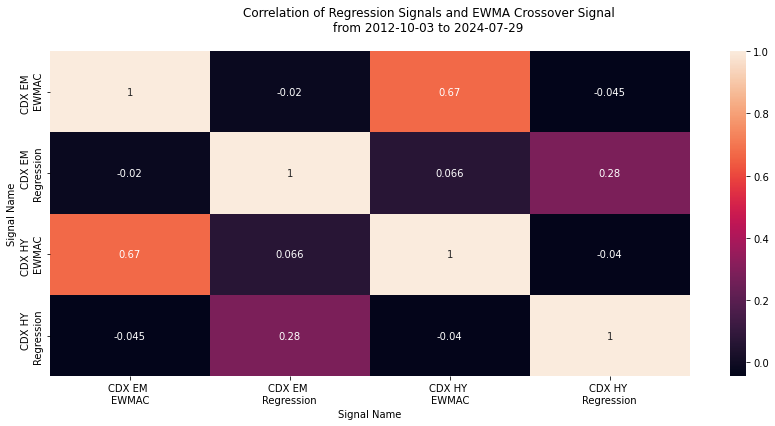

In [8]:
def plot_correlation_matrix(df_regression: pd.DataFrame, df_ewmac: pd.DataFrame) -> plt.Figure: 
     
    fig, axes = plt.subplots(figsize = (12,6))

    df_corr = get_correlation(df_regression, df_ewmac)
    sns.heatmap(
        data = df_corr,
        annot = True,
        ax = axes)

    fig.suptitle("Correlation of Regression Signals and EWMA Crossover Signal\nfrom {} to {}".format(
        df_regression.date.min().date(),
        df_regression.date.max().date()))
    
    plt.tight_layout()
    
plot_correlation_matrix(df_regression, df_ewmac)

The authors argue that the signals are much more correlated. These results are differ from their claim, although they claim to use "20d" regression, not sure if thats 20d shifted full-sample regression or 20d rolling regression against lagged values. In this case regression here is defined as 20d rolling regression of 20d lagged spread. 

Now apply the signal to get the index returns. 

In [9]:
def _apply_signal(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(signal_rtn = lambda x: np.sign(x.signal) * x.rtn))
    
    return df_out

def get_signal_rtn(df_regression: pd.DataFrame, df_ewmac: pd.DataFrame, df_index: pd.DataFrame) -> pd.DataFrame: 

    df_regress_tmp = (df_regression[
        ["date", "lag_beta", "security"]].
        rename(columns = {"lag_beta": "signal"}))

    df_ewmac_tmp = (df_ewmac[
        ["date", "security", "lag_signal"]].
        rename(columns = {
            "lag_signal": "signal"}))

    df_signal_rtn = (pd.concat([
        df_ewmac_tmp.assign(signal_kind = "ewmac"), df_regress_tmp.assign(signal_kind = "regress")]).
        rename(columns = {"security": "spread_security"}).
        assign(group_name = lambda x: x.spread_security.str.split(" ").str[1]).
        merge(right = df_index, how = "inner", on = ["date", "group_name"]).
        groupby(["signal_kind", "group_name"]).
        apply(_apply_signal))
    
    return df_signal_rtn

df_signal_rtn = get_signal_rtn(df_regression, df_ewmac, df_index)

In [10]:
def get_wider_rtn(df_signal_rtn: pd.DataFrame) -> pd.DataFrame: 
    
    df_wider = (df_signal_rtn.assign(
        strat_name = lambda x: x.spread_security.str.split("CDSI").str[0] + np.where(x.signal_kind == "ewmac", x.signal_kind.str.upper(), x.signal_kind.str.capitalize()))
        [["strat_name", "signal_rtn", "date"]].
        rename(columns = {"strat_name": "Strat Name"}).
        pivot(index = "date", columns = "Strat Name", values = "signal_rtn"))
    
    return df_wider

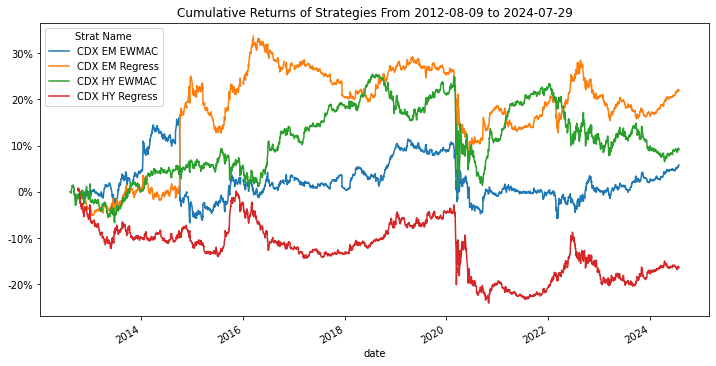

In [11]:
def plot_cumulative_rtn(df_signal_rtn: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (12,6))

    (get_wider_rtn(
        df_signal_rtn = df_signal_rtn).
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax = axes,
            title = "Cumulative Returns of Strategies From {} to {}".format(
                df_signal_rtn.date.min().date(),
                df_signal_rtn.date.max().date())))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    
plot_cumulative_rtn(df_signal_rtn)

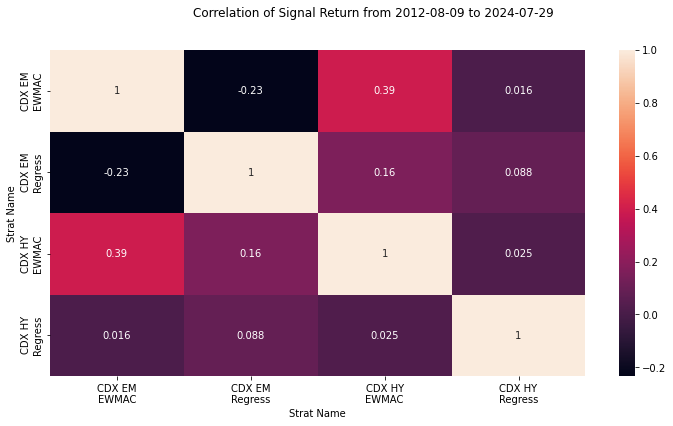

In [12]:
def plot_signal_rtn_corr(df_signal_rtn: pd.DataFrame) -> plt.Figure:
    
    fig, axes = plt.subplots(figsize = (12,6))
    df_corr = (get_wider_rtn(
        df_signal_rtn = df_signal_rtn).
        reset_index().
        melt(id_vars = "date").
        rename(columns = {"Strat Name": "strat_name"}).
        assign(strat_name = lambda x: x.strat_name.str.split(" ").str[0] + " " + x.strat_name.str.split(" ").str[1] + "\n" + x.strat_name.str.split(" ").str[2]).
        rename(columns = {"strat_name": "Strat Name"}).
        pivot(index = "date", columns = "Strat Name", values = "value").
        corr())
    
    sns.heatmap(
        data = df_corr,
        ax = axes,
        annot = True)
    
    fig.suptitle("Correlation of Signal Return from {} to {}".format(
            df_signal_rtn.date.min().date(),
            df_signal_rtn.date.max().date()))
    
plot_signal_rtn_corr(df_signal_rtn)

The authors use a volatility target of 10%.

In [13]:
def _get_rolling_vol(df: pd.DataFrame, lookback: int, vol_target: float) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(
            signal_vol = lambda x: x.value.rolling(window = lookback).std() * np.sqrt(252) * 100,
            weighting = lambda x: vol_target / x.signal_vol,
            lag_weighting = lambda x: x.weighting.shift(),
            signal_rtn = lambda x: x.lag_weighting * x.value).
        dropna())
    
    return df_out

def vol_target(df_signal_rtn: pd.DataFrame, lookback: int = 30, vol_target: float = 10) -> pd.DataFrame: 

    df_tmp = (get_wider_rtn(df_signal_rtn).reset_index().melt(
        id_vars = "date").
        rename(columns = {"Strat Name": "strat_name"}).
        groupby("strat_name").
        apply(_get_rolling_vol, lookback, vol_target).
        reset_index(drop = True))
    
    return df_tmp

df_vol_target = vol_target(df_signal_rtn)

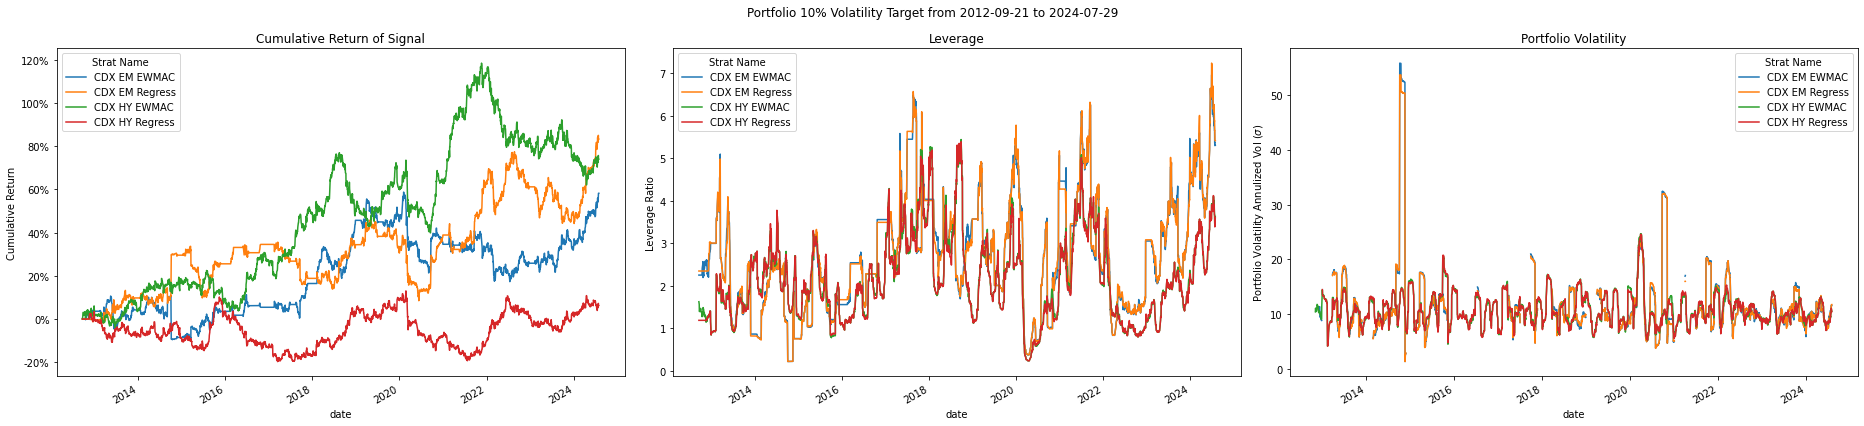

In [15]:
def plot_portfolio_target(df_vol_target: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df_vol_target[
        ["date", "strat_name", "signal_rtn", "lag_weighting", "weighting"]].
        melt(id_vars = ["date", "strat_name"]))
    
    fig, axes = plt.subplots(ncols = 3, figsize = (26,6))

    vol1 = r"$\sigma$"
    vol_name = "Portfolio Volatility Annulized Vol (" + vol1 + ")"

    (df_tmp.query(
        "variable == 'signal_rtn'").
        drop(columns = ["variable"]).
        rename(columns = {"strat_name": "Strat Name"}).
        pivot(index = "date", columns = "Strat Name", values = "value").
        fillna(0).
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax = axes[0],
            ylabel = "Cumulative Return",
            title = "Cumulative Return of Signal"))

    (df_tmp.query(
        "variable == 'weighting'").
        drop(columns = ["variable"]).
        rename(columns = {"strat_name": "Strat Name"}).
        pivot(index = "date", columns = "Strat Name", values = "value").
        fillna(method = "bfill").
        plot(
            ax = axes[1],
            ylabel = "Leverage Ratio",
            title = "Leverage"))

    (df_tmp.query(
        "variable == 'signal_rtn'").
        drop(columns = ["variable"]).
        rename(columns = {"strat_name": "Strat Name"}).
        pivot(index = "date", columns = "Strat Name", values = "value").
        apply(lambda x: x.rolling(window = 30).std() * np.sqrt(252) * 100).
        plot(
            ax = axes[2],
            title = "Portfolio Volatility",
            ylabel = vol_name))

    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    fig.suptitle("Portfolio 10% Volatility Target from {} to {}".format(
        df_tmp.date.min().date(),
        df_tmp.date.max().date()))

    plt.tight_layout()
    
plot_portfolio_target(df_vol_target)